In [1]:
import sys
sys.path.append('../')
import numpy
import pandas
import seaborn

from deepracer.tracks import TrackIO, Track

from deepracer.logs import \
    AnalysisUtils as au, \
    SimulationLogsIO as slio, \
    EvaluationUtils as eu, \
    PlottingUtils as pu,\
    NewRewardUtils as nr \

from reward import AWSReward, RewardFactory
import reward.awsreward as rewards
from utils.loader import get_df, load_sample_complete_laps
from utils.transformer import df_to_params, new_names_df, get_episode
from utils.new_rewards import aggregate_episode_reward, summary
track = TrackIO(base_path='../tracks').load_track("reinvent_base")
fname = '../logs/training-simulation-logs-w7.log'

full_df= get_df(fname)
import warnings
warnings.filterwarnings('ignore')

Loaded 71 waypoints


In [2]:
class NewReward(AWSReward):
    max_speed    = 1.0
    
    def _calculateReward(self):
        return self.x + self.y

In [3]:
def plot_new_reward(df,reward_names):
    import seaborn

    new_df = df.loc[:,['duration','step'] + [f'cumulative_{n}' for n in reward_names] ]
    new_df = new_df.set_index('duration').sort_index()
    seaborn.lineplot(data=new_df,)

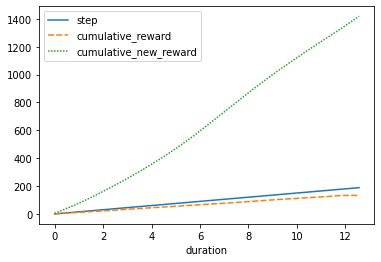

In [4]:
df = aggregate_episode_reward(get_episode(full_df,1),NewReward, df_to_params, track, 'new_reward')
plot_new_reward(df,['reward','new_reward'])

In [5]:
summary(df,['new_reward'])

,,step,closest_waypoint_index,progress,speed,time,reward,duration,new_reward
iteration,episode,,,,,,,,
1,1,189,4,48.9639,0.629365,00:00:12,133.469,12.568453,1418.5668


# Evaluate in new_reward in sample_complete_laps

In [6]:
sample_complete_laps_path = '../logs/sample_complete_laps.csv'
scl_df = load_sample_complete_laps(sample_complete_laps_path)

In [7]:
cum_scl = aggregate_episode_reward(scl_df,NewReward, df_to_params, track, 'new_reward')

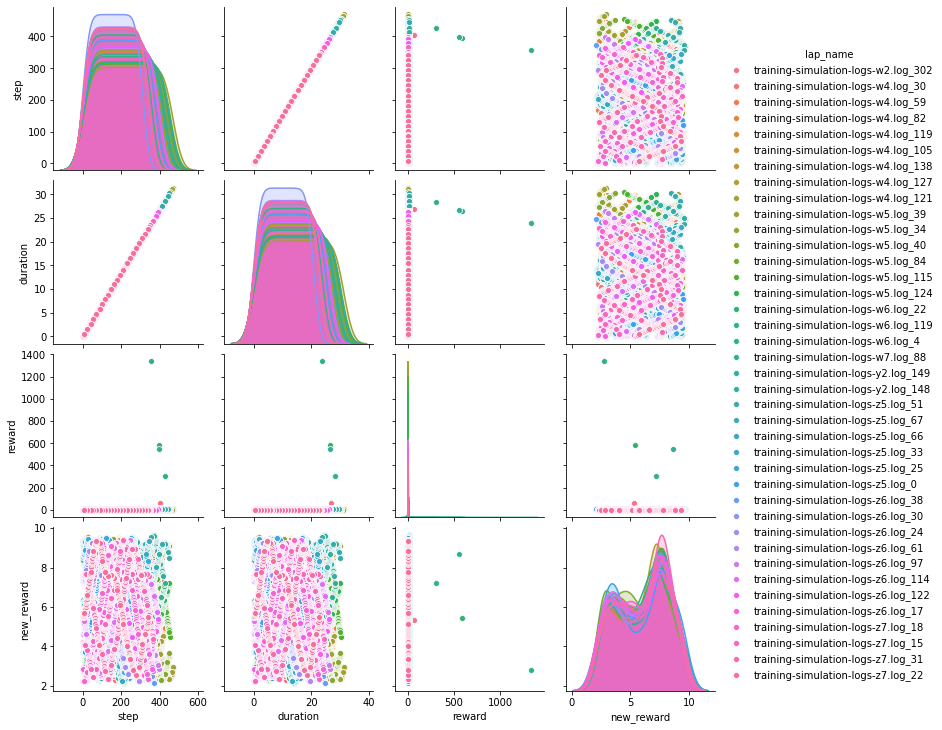

In [9]:
cols = ['step','duration','lap_name','reward','new_reward']
seaborn.pairplot(cum_scl[cols],hue='lap_name',palette="husl")

In [10]:
cols = ['stream','time','step','stream','speed','duration','reward','new_reward', 'lap_name']
aditional_map = {'lap_name': max}
summ_scl  = summary(cum_scl,['reward','new_reward'],use_stream=True,aditional_maps=aditional_map).reset_index()[cols]

In [11]:
filtered_summ = pandas.concat( [ summ_scl.nlargest(5,'duration'),
                                summ_scl.nsmallest(5,'duration')
                               ])
filtered_summ

,stream,time,step,stream,speed,duration,reward,new_reward,lap_name
10,training-simulation-logs-w5.log,00:00:31,470,training-simulation-logs-w5.log,0.534574,31.355924,349.8823,2818.2885,training-simulation-logs-w5.log_39
13,training-simulation-logs-w5.log,00:00:31,456,training-simulation-logs-w5.log,0.535373,30.390635,335.7802,2719.0539,training-simulation-logs-w5.log_115
8,training-simulation-logs-w4.log,00:00:30,453,training-simulation-logs-w4.log,0.555099,30.200349,321.0741,2751.1411,training-simulation-logs-w4.log_138
19,training-simulation-logs-y2.log,00:00:31,452,training-simulation-logs-y2.log,0.556615,30.179048,3334.2752,2691.3954,training-simulation-logs-y2.log_148
11,training-simulation-logs-w5.log,00:00:30,452,training-simulation-logs-w5.log,0.536128,30.157656,341.7103,2655.0662,training-simulation-logs-w5.log_40
29,training-simulation-logs-z6.log,00:00:20,311,training-simulation-logs-z6.log,0.719164,20.722651,1096.1986,1881.3478,training-simulation-logs-z6.log_30
31,training-simulation-logs-z6.log,00:00:22,338,training-simulation-logs-z6.log,0.677189,22.521142,1161.1744,1991.5918,training-simulation-logs-z6.log_61
26,training-simulation-logs-z5.log,00:00:23,340,training-simulation-logs-z5.log,0.684353,22.655967,1226.9454,2087.1230,training-simulation-logs-z5.log_67
22,training-simulation-logs-z5.log,00:00:22,341,training-simulation-logs-z5.log,0.684076,22.721786,1205.9362,2082.8275,training-simulation-logs-z5.log_25
37,training-simulation-logs-z7.log,00:00:22,341,training-simulation-logs-z7.log,0.673226,22.737218,846.2649,2083.2443,training-simulation-logs-z7.log_22


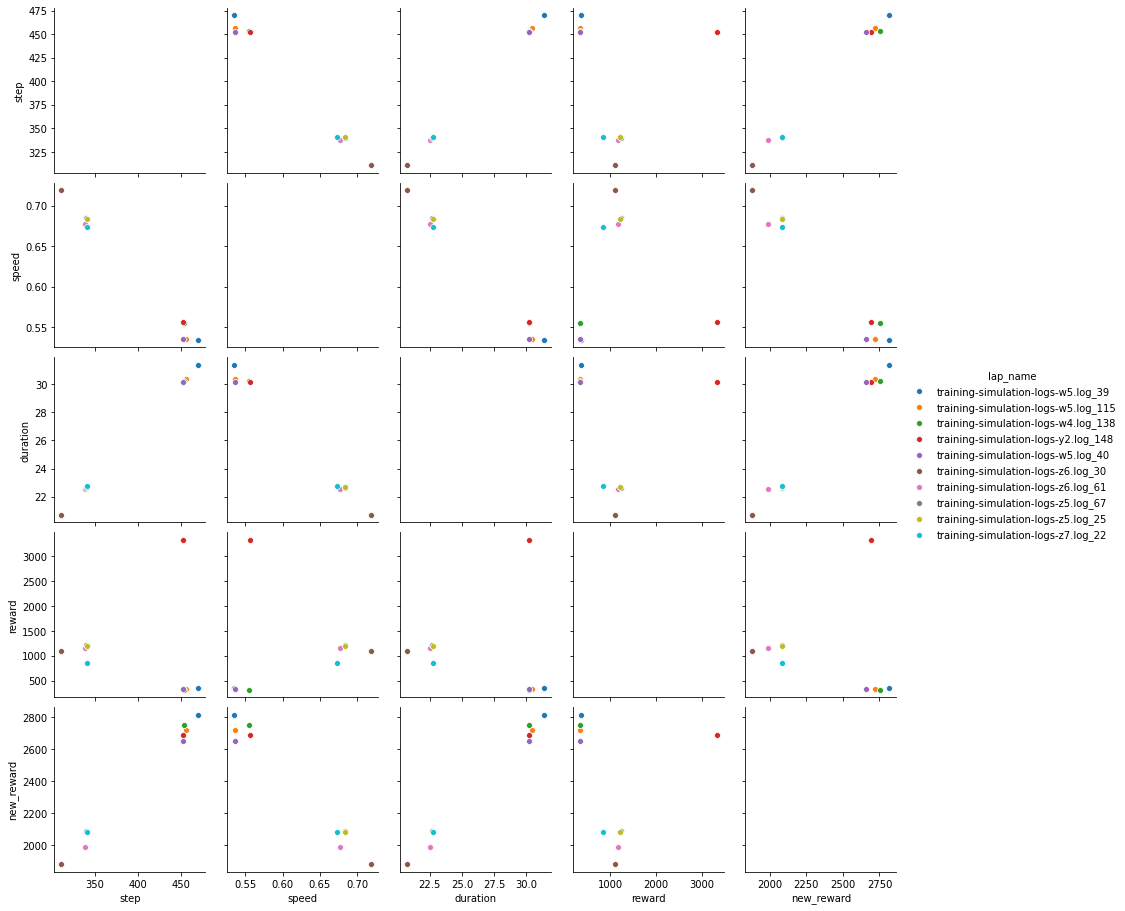

In [12]:
seaborn.pairplot(filtered_summ,hue='lap_name')

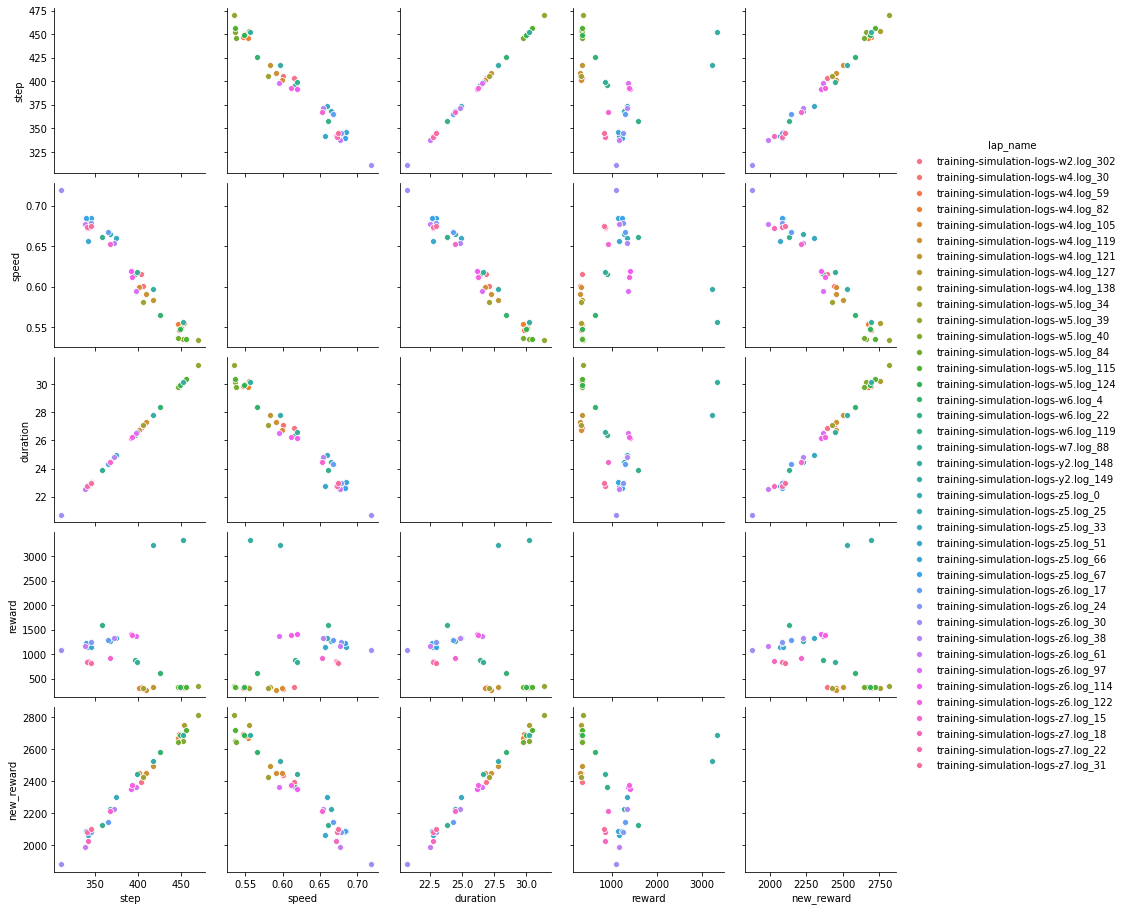

In [13]:
seaborn.pairplot(summ_scl,hue='lap_name')

In [14]:
laps = ['training-simulation-logs-z6.log_30','training-simulation-logs-w5.log_39']
filtered_by_lap_summ = summ_scl[summ_scl.lap_name.isin(laps)]
filtered_by_lap_summ

,stream,time,step,stream,speed,duration,reward,new_reward,lap_name
10,training-simulation-logs-w5.log,00:00:31,470,training-simulation-logs-w5.log,0.534574,31.355924,349.8823,2818.2885,training-simulation-logs-w5.log_39
29,training-simulation-logs-z6.log,00:00:20,311,training-simulation-logs-z6.log,0.719164,20.722651,1096.1986,1881.3478,training-simulation-logs-z6.log_30


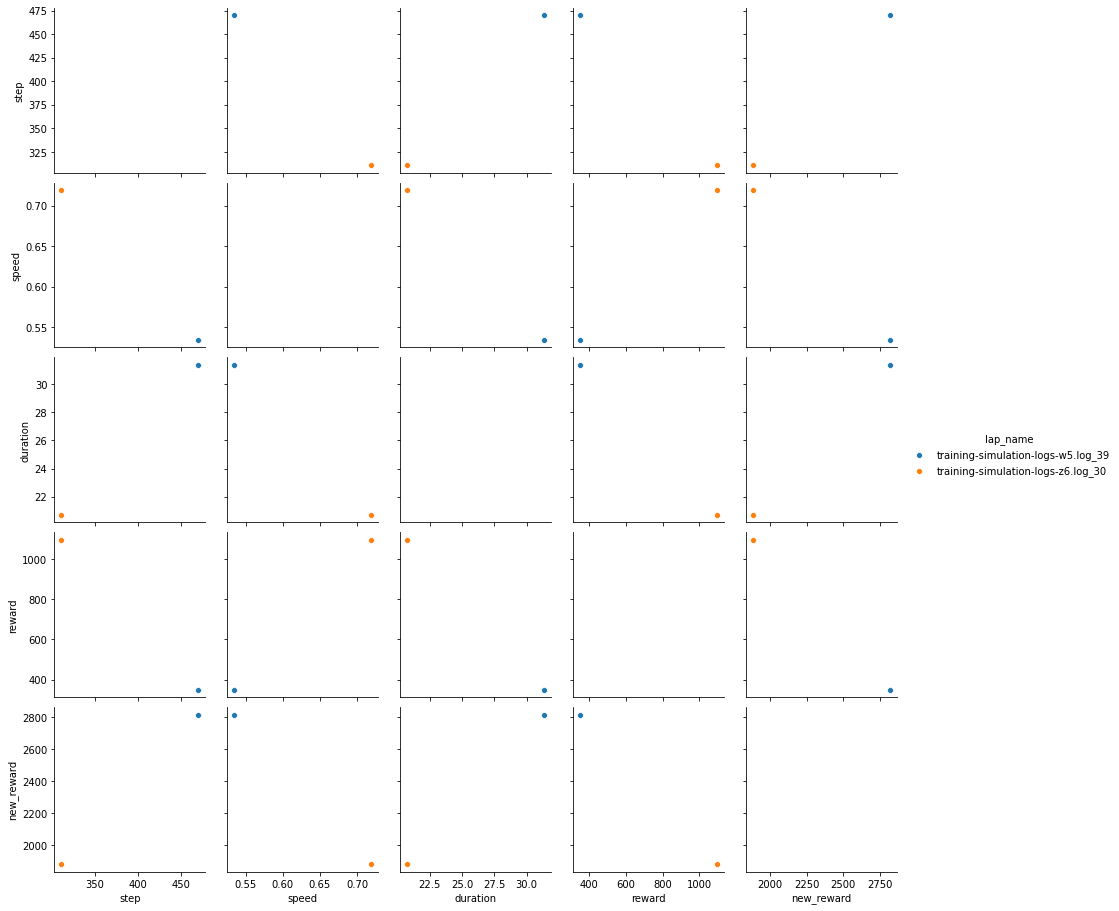

In [15]:
seaborn.pairplot(filtered_by_lap_summ,hue='lap_name')